## Date Transform from Human Format to Machine Format

In [1]:
import numpy as np
import pandas as pd
from faker import Faker
from babel.dates import format_date
import random
from tqdm import tqdm
import tensorflow as tf
from keras.layers import TextVectorization, Input, LSTM, Embedding, Dense, Concatenate, Attention, RepeatVector, Dot, Activation, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam
import mlflow
from datetime import datetime 
import re
import os 


### Function Definitions

In [2]:
def generate_date():
    """
    _summary_

    Returns
    -------
    _type_
        _description_
    """

    # Define format of the data we would like to generate
    FORMATS = ['short', 'medium', 'long'] \
            + ['full']*10 \
            + ['d MMM YYY', 'd MMMM YYY', 'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY', 'd MM YY', 'd MMMM YYY', 'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']

    faker = Faker()
    dt = faker.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
    _summary_

    Parameters
    ----------
    m : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    
    # human_vocab = set()
    # machine_vocab = set()
    dataset = []
    #Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = generate_date()
        if h is not None:
            dataset.append((h, m))
            #human_vocab.update(tuple(h))
            #machine_vocab.update(tuple(m))
    
    # human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
    #                  list(range(len(human_vocab) + 2))))
    # inv_machine = dict(enumerate(sorted(machine_vocab)))
    # machine = {v:k for k,v in inv_machine.items()}
 
    return dataset#, human, machine, inv_machine

def process_data(dataset, Tx, Ty, verbose=False):
    """
    Transform source dataset from date string representation to one-hot encoded.

    Parameters
    ----------
    dataset : list
        An array of tuples with human date and corresponding machine date
    """

    X, y = zip(*dataset)

    X = np.array(X)
    y = np.array(y)
    print(X.shape)

    tokenizer_X = TextVectorization(split='character', standardize='lower')
    tokenizer_y = TextVectorization(split='character', standardize='lower')

    tokenizer_X.adapt(X)
    tokenizer_y.adapt(y)

    # Get the vocabulary (list of tokens)
    vocab_X = tokenizer_X.get_vocabulary()
    vocab_y = tokenizer_y.get_vocabulary()
    # Create the mapping from character to index
    char_to_index_X = {char: index for index, char in enumerate(vocab_X)}
    char_to_index_y = {char: index for index, char in enumerate(vocab_y)}
    # Create the mapping from index to character
    index_to_char_X = {index: char for index, char in enumerate(vocab_X)}
    index_to_char_y = {index: char for index, char in enumerate(vocab_y)}

    _,_, X_tokenized_pad_oh = prepare_X(X=X,X_vis='X', tokenizer=tokenizer_X, max_len=Tx, vocab=char_to_index_X, idx_vis=5, verbose=verbose)
    _,_, y_tokenized_pad_oh = prepare_X(X=y, X_vis='y', tokenizer=tokenizer_y, max_len=Ty, vocab=char_to_index_y, idx_vis=5, verbose=verbose)

    if verbose:
        print('X.shape: ', X.shape)
        print('y.shape: ', y.shape)
        print(f'char_to_index_X ({len(char_to_index_X)}): ', char_to_index_X)
        print(f'char_to_index_y ({len(char_to_index_y)}): ', char_to_index_y)
        print(f'index_to_char_X ({len(index_to_char_X)}): ', index_to_char_X)
        print(f'index_to_char_y ({len(index_to_char_y)}): ', index_to_char_y)   

    #return X_tokenized_pad, y_tokenized_pad, X_tokenized_pad_oh, y_tokenized_pad_oh, char_to_index_X, char_to_index_y, index_to_char_y
    return X_tokenized_pad_oh, y_tokenized_pad_oh, char_to_index_X, char_to_index_y, index_to_char_X, index_to_char_y, tokenizer_X, tokenizer_y

def prepare_X(X, X_vis, tokenizer, max_len, vocab, idx_vis, verbose=False):
    """
    Convert the input array of strings X into one-hot encoded chars of these strings

    Parameters
    ----------
    X : _type_
        _description_
    X_name : string
        Name of the variable X. Use only for verbose output visualization.
    tokenizer : TextVectorization
        Tokenizer used for tokenizing training data.
    Tx : max length of strings
        _description_
    vocab : _type_
        _description_
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """
    # tokenize X (convert chars to numbers)
    X_tokenized = np.array(tokenizer(X))

    # pad sequences till Tx if length of string is less than Tx, otherwise - cut it till Tx
    X_tokenized_pad = np.array([np.pad(s, pad_width=(0, max_len-len(s))) if len(s) < max_len else s[:len(s)] for s in X_tokenized])
    
    # one-hot encode numbers
    X_tokenized_pad_oh = np.array([to_categorical(s, num_classes=len(vocab)) for s in X_tokenized_pad])

    if verbose:
        print(f'For variable {X_vis}')
        print(f'{X_vis}_tokenized.shape: ', X_tokenized.shape)
        print(f'{X_vis}_tokenized_pad.shape: ', X_tokenized_pad.shape)
        print(f'{X_vis}_tokenized_pad_oh.shape: ', X_tokenized_pad_oh.shape)
        print(f'{X_vis}_vocab: ', vocab)
        print(f'for idx = {idx_vis}')
        print(f'{X_vis}[{idx_vis}]: ', X[idx_vis])
        print(f'{X_vis}_tokenized[{idx_vis}]: ', X_tokenized[idx_vis])
        print(f'{X_vis}_tokenized_pad[{idx_vis}]: ', X_tokenized_pad[idx_vis])
        print(f'{X_vis}_tokenized_pad_oh[{idx_vis}]: ', X_tokenized_pad_oh[idx_vis])
        print()
        
    return X_tokenized, X_tokenized_pad, X_tokenized_pad_oh

    
def softmax_custom(x, axis=1):
    """Softmax activation function.
    
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied (default is -1).
    
    # Returns
        Tensor, output of softmax transformation.
    
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    #print(type(x))
    #print(x.shape)
    #print('*** softmax_custom ***')

    ndim = x.shape[1]
    if ndim == 2:
        return tf.nn.softmax(x)
    elif ndim > 2:
        e = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))  # Use TensorFlow's exp
        s = tf.reduce_sum(e, axis=axis, keepdims=True)  # Use TensorFlow's sum
        
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
    
    

    # try:
    #     # Attempt to apply softmax using Keras' built-in function
    #     return K.softmax(x, axis=axis)
    # except Exception as e:
    #     # Handle exceptions and provide a useful message
    #     raise ValueError(f'Error applying softmax: {str(e)}')


def build_model_rnn(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """

    def one_step_attention(a, s_prev):
        """
        Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
        "alphas" and the hidden states "a" of the Bi-LSTM.
        
        Arguments:
        a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
        s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
        
        Returns:
        context -- context vector, input of the next (post-attention) LSTM cell
        """
        
        # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
        s_prev = repeator(s_prev)
        # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
        # For grading purposes, please list 'a' first and 's_prev' second, in this order.
        concat = concatenator([a,s_prev])
        # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
        e = densor1(concat)
        # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
        energies = densor2(e)
        # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
        alphas = activator(energies)
        #print("alphas:", alphas)
        # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
        context = dotor([alphas,a])

        return context, alphas, energies, e
    

    # Defined shared layers as global variables
    repeator = RepeatVector(Tx)
    concatenator = Concatenate(axis=-1)
    densor1 = Dense(10, activation = "tanh")
    densor2 = Dense(1, activation = "tanh")
    activator = Activation(softmax_custom, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
    dotor = Dot(axes = 1)
    # Please note, this is the post attention LSTM cell.  
    post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
    output_layer = Dense(len(char_to_index_y), activation=softmax_custom)

    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, len(char_to_index_X)))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    attention_weights = []
    energies_weights = []
    e_weights = []
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context, alphas, energies, e = one_step_attention(a, s)
        #print('alphas... \n', alphas)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
        attention_weights.append(alphas)
        energies_weights.append(energies)
        e_weights.append(e)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X, s0, c0],outputs=outputs)
    
    attention_model = Model(inputs=[X, s0, c0], outputs=attention_weights)
    attention_inspector = Model(inputs=[X, s0, c0], outputs=[attention_weights, energies_weights, e_weights])
    
    return model, attention_model, attention_inspector




def log_experiment(experiment_name, run_name, model, input_example, run_metrics, run_params=None, run_tags=None, run_artifacts_png=None):
    """
    Loging of experiments.

    Parameters
    ----------
    experiment_name : _type_
        _description_
    model : _type_
        _description_
    input_example : _type_
        _description_
    run_name : _type_
        _description_
    run_metrics : _type_
        _description_
    run_params : _type_, optional
        _description_, by default None
    run_tags : _type_, optional
        _description_, by default None
    run_artifacts_png : _type_, optional
        _description_, by default None
    """
    print('*** log_experiment ***')
    
    import mlflow.sklearn

    #mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name) as run:
        # log metrics
        for m in run_metrics:
            if run_metrics[m]:
                mlflow.log_metric(m, run_metrics[m])
        # log model
        mlflow.sklearn.log_model(sk_model=model, artifact_path='model', input_example=input_example)
        # log params
        if run_params:
            for p in run_params.items():
                mlflow.log_param(key=p[0], value=p[1])
        # log tags
        if run_tags:
            for t in run_tags.items():
                mlflow.set_tag(key=t[0], value=t[1])
        # log artifacts
        if run_artifacts_png:
            for a in run_artifacts_png:
                if os.path.exists(a):
                    mlflow.log_artifact(a)
        
    print('Run - is logged.')

    # Get the run id
    run_id = run.info.run_id
    experiment_id = run.info.experiment_id
    experiment = mlflow.get_experiment(experiment_id)
    print(f'experiment name: {experiment.name}')
    print(f'experiment id: {experiment.experiment_id}')
    print('run_name: ', run.info.run_name)
    print('run_id: ', run_id)
    

def clean_png():
    """
    Clean all .png files in the current folder.
    """

    import os
    import glob

    # Get the current directory
    current_dir = os.getcwd()

    # Find all .png files in the current directory
    png_files = glob.glob(os.path.join(current_dir, "*.png"))

    # Loop through the list of .png files and delete them
    for file in png_files:
        try:
            os.remove(file)
            print(f"Deleted: {file}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")

    print("All .png files have been deleted.")

def get_png():
    """
    Get the list of .png files in the current folder.

    Returns
    -------
    _type_
        _description_
    """

    import os
    import glob

    # Get the current directory
    current_dir = os.getcwd()

    # Find all .png files in the current directory
    png_files = glob.glob(os.path.join(current_dir, "*.png"))

    return png_files



### Generate and Load Data

In [3]:
m = 10000
dataset_train = load_dataset(m)
dataset_test = load_dataset(m=300)
dataset_train[:10]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 1827.61it/s]


[('15 09 06', '2006-09-15'),
 ('16.03.23', '2023-03-16'),
 ('01 jul 1991', '1991-07-01'),
 ('9 january 1998', '1998-01-09'),
 ('20 12 98', '1998-12-20'),
 ('3 december 1982', '1982-12-03'),
 ('07 mar 2013', '2013-03-07'),
 ('monday july 10 2000', '2000-07-10'),
 ('saturday november 26 1983', '1983-11-26'),
 ('tuesday august 2 2016', '2016-08-02')]

### Process Data

In [4]:
X_tokenized_pad_oh, y_tokenized_pad_oh, char_to_index_X, char_to_index_y, index_to_char_X, index_to_char_y, tokenizer_X, tokenizer_y = process_data(dataset=dataset_train, Tx=30, Ty=10, verbose=False)
X_tokenized_pad_oh_test, y_tokenized_pad_oh_test, _, _, _, _, _, _ = process_data(dataset=dataset_test, Tx=30, Ty=10, verbose=False)

(10000,)
For variable X
X_tokenized.shape:  (10000, 27)
X_tokenized_pad.shape:  (10000, 30)
X_tokenized_pad_oh.shape:  (10000, 30, 37)
X_vocab:  {'': 0, '[UNK]': 1, ' ': 2, '1': 3, '2': 4, 'a': 5, '0': 6, '9': 7, 'e': 8, 'r': 9, 'y': 10, 'u': 11, 'd': 12, 's': 13, 'n': 14, '7': 15, 'm': 16, '8': 17, 't': 18, 'b': 19, '3': 20, 'o': 21, '4': 22, 'j': 23, 'c': 24, '5': 25, '6': 26, 'p': 27, 'l': 28, 'h': 29, 'f': 30, 'i': 31, '.': 32, '/': 33, 'v': 34, 'g': 35, 'w': 36}
for idx = 5
X[5]:  3 december 1982
X_tokenized[5]:  [20  2 12  8 24  8 16 19  8  9  2  3  7 17  4  0  0  0  0  0  0  0  0  0
  0  0  0]
X_tokenized_pad[5]:  [20  2 12  8 24  8 16 19  8  9  2  3  7 17  4  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
X_tokenized_pad_oh[5]:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]

For variable y
y_tokenized.shape:  (10000, 10)
y_tokenized_pad.shape:  (10000, 10)
y_tokenized_pa

### Build RNN network with Attention

We are going to nuild a RNN network with attention according to the following design:

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>

In [87]:
def predict_model(model, date, n_s, index_to_char_y, tokenizer_X, tokenizer_y, char_to_index_X, Tx, verbose=False):
    """
    Return translation of the human written date to unified machine date format.

    Parameters
    ----------
    date : str or list or np.ndarray
        A date string or an array of date strings

    Returns
    -------
    A date string or an array of date strings in unified machine format.
    """
    print('*** predict_model *** ')
    
    assert isinstance(date, np.ndarray) or isinstance(date, list) or isinstance(date, str), 'date MUST be a string of date or an array of date strings.'
    
    if isinstance(date, str):
        print(type(date))
        date=np.array([date])
        print(type(date))
        print(date)
        print(len(date))
        
    s0 = np.zeros((len(date),n_s))
    c0 = np.zeros((len(date),n_s))
    # s0 = np.zeros(1,n_s)
    # c0 = np.zeros(1,n_s)

    # prepare test examples
    _,_, X_tokenized_pad_oh_test = prepare_X(X=date, X_vis='X', tokenizer=tokenizer_X, max_len=Tx, vocab=char_to_index_X, idx_vis=0, verbose=verbose)

    #print('X_tokenized_pad_oh_test.shape', X_tokenized_pad_oh_test.shape)
    #print('s0, c0: ',  s0, c0)

    # predict
    pred_softmax = model.predict([X_tokenized_pad_oh_test, s0, c0], verbose=verbose)
    pred_num = np.argmax(pred_softmax, axis=-1)
    pred_char = [[index_to_char_y[n] for n in e] for e in pred_num]
    pred_joined = [''.join(e) for e in np.array(pred_char).T]

    result_df = pd.DataFrame({'test_examples': date, 'pred': pred_joined})

    return result_df


def get_metrics_from_model(y_true, y_pred, verbose=False):
    """
    _summary_

    Parameters
    ----------
    y_true : _type_
        _description_
    y_pred : _type_
        _description_
    y_pred_prob : _type_
        _description_
    verbose : bool, optional
        _description_, by default False

    Returns
    -------
    _type_
        _description_
    """
    print('*** get_metrics ***')

    acc = (y_true == y_pred).mean()
    
    metrics = {
        'test_accuracy': round(acc, 2), 
        }
    
    if verbose:
        print('metrics: ', metrics)

    return metrics


def clean_history(model_history):

    history_df = pd.DataFrame(model_history.history)

    history_df.rename({'loss': 'train_loss'}, axis=1, inplace=True)

    selected_columns = [col for col in history_df.columns if not re.search(r'^(val_)?dense_[0-9]{1,3}_(train|loss)$', col)]
    history_df = history_df[selected_columns]
    #print('1', history_df.columns)
    history_df.columns = history_df.columns.str.replace(r'^val_dense_[0-9]{1,3}_accuracy$', 'val_accuracy_0', regex=True)
    history_df.columns = history_df.columns.str.replace(r'^dense_[0-9]{1,3}_accuracy$', 'train_accuracy_0', regex=True)
    #print('2', history_df.columns)
    history_df.columns = history_df.columns.str.replace(r'^dense_[0-9]{1,3}_loss$', 'train_loss', regex=True)
    history_df.columns = [re.sub(r'^val_dense_[0-9]{1,3}', 'val', col) for col in history_df.columns]
    history_df.columns = [re.sub(r'dense_[0-9]{1,3}_', 'train_', col) for col in history_df.columns]
    #print('3', history_df.columns)

    return history_df


def get_metrics_from_history(history_df):
    
    metrics = {col:np.round(history_df[col].values[-1],4)  for col in history_df.columns}

    return metrics


def plot_metrics_vs_epoch(history_df, file_name):
    """
    Plot model fit metrics vs epoch.

    Parameters
    ----------
    model_history : _type_
        _description_
    """
    import re 
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    #history_df = pd.DataFrame(model_history.history)

    # p = re.compile(r'loss$')
    # cols_vis = list(filter(lambda x: not p.search(x), history_df.columns))
    
    cols_vis_accuracy = [c for c in history_df.columns if re.search('.*accuracy.*', c)]
    cols_vis_loss = [c for c in history_df.columns if re.search('.*loss.*', c)]

    # Create a figure and 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for c in cols_vis_accuracy:
        sns.lineplot(x=history_df.index, y=history_df[c], label=c, ax=ax1)

    for c in cols_vis_loss:
        sns.lineplot(x=history_df.index, y=history_df[c], label=c, ax=ax2)

    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(loc='upper left')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=4, fontsize=8)
    

    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    

    # Show the plot
    plt.tight_layout()

    plt.savefig(file_name)
    plt.show()


def log_experiment(experiment_name, run_name, model, input_example, run_metrics, run_params=None, run_tags=None, run_artifacts_png=None):
    """
    Loging of experiments.

    For logging keras model check this: https://medium.com/@rajavenkatesrajamanickam/mlflow-integration-with-keras-3309fd9fb6c9

    Parameters
    ----------
    experiment_name : _type_
        _description_
    model : _type_
        _description_
    input_example : _type_
        _description_
    run_name : _type_
        _description_
    run_metrics : _type_
        _description_
    run_params : _type_, optional
        _description_, by default None
    run_tags : _type_, optional
        _description_, by default None
    run_artifacts_png : _type_, optional
        _description_, by default None
    """
    print('*** log_experiment ***')
    
    import mlflow.sklearn

    #mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name) as run:
        # log metrics
        for m in run_metrics:
            if run_metrics[m]:
                mlflow.log_metric(m, run_metrics[m])
        # log model
        #mlflow.keras.log_model(model, artifact_path='model', input_example=input_example)
        mlflow.keras.log_model(model, artifact_path='model')
        # log params
        if run_params:
            for p in run_params.items():
                mlflow.log_param(key=p[0], value=p[1])
        # log tags
        if run_tags:
            for t in run_tags.items():
                mlflow.set_tag(key=t[0], value=t[1])
        # log artifacts
        if run_artifacts_png:
            for a in run_artifacts_png:
                if os.path.exists(a):
                    mlflow.log_artifact(a)
        
        print('Run - is logged.')

        # Get the run id
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id
        experiment = mlflow.get_experiment(experiment_id)
        print(f'experiment name: {experiment.name}')
        print(f'experiment id: {experiment.experiment_id}')
        print('run_name: ', run.info.run_name)
        print('run_id: ', run_id)

In [92]:
import re
import warnings
from mlflow.exceptions import MlflowException
import time
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module='mlflow.keras.save')


Tx=30 # the size of the input human date sequence (in chars)
Ty=10 # the size of the output machine sequence (in chars)

# Define a list of different hyperparameters to test
na = [32, 16, 64] # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
ns = [32, 64, 128] # number of units for the post-attention LSTM's hidden state "s"
# na = [32]
# ns = [32]

for na_ in na:
    for ns_ in ns:
        
        clean_png()

        print(f'Experiment: na: {na_}, ns: {ns_}.')
        m = len(X_tokenized_pad_oh)
        #print('m: ', m)

        # Build and train the model
        s0 = np.zeros((m, ns_))
        c0 = np.zeros((m, ns_))
        model_rnn, attention_model, attention_inspector = build_model_rnn(Tx, Ty, na_, ns_, len(char_to_index_X), len(char_to_index_y))
        # compile model
        opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
        model_rnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']*Ty)


        outputs = list(y_tokenized_pad_oh.swapaxes(0,1))
        start_fit_time = time.time()
        history = model_rnn.fit([X_tokenized_pad_oh, s0, c0], outputs, epochs=10, batch_size=64, verbose=False, validation_split=0.2)
        end_fit_time = start_time = time.time()


        history_df = clean_history(model_history=history)

        metrics = get_metrics_from_history(history_df=history_df)
        
        params = {'na': na_, 'ns': ns_, 'fitting_time_s': end_fit_time - start_fit_time}

        X_test, y_test = zip(*dataset_test)
        X_test = np.array(X_test)
    
        #print(X_test[0])
        #print(X_test.shape)

        pred_df = predict_model(
            model=model_rnn, 
            date=X_test, 
            n_s=ns_, 
            index_to_char_y=index_to_char_y, 
            tokenizer_X=tokenizer_X, 
            tokenizer_y=tokenizer_y, 
            char_to_index_X=char_to_index_X, 
            Tx=Tx, 
            verbose=False)
        
        #print('preds: ', pred_df.head())

        metrics_model = get_metrics_from_model(y_true=y_test, y_pred=pred_df['pred'].values)
        metrics.update(metrics_model)

        # Log custom metrics like accuracy on test data
        
        #metrics["test_accuracy"] = test_acc
        print('metrics: ', metrics)
        print('params: ', params)
        
        #plot_metrics_vs_epoch(history_df=history_df[['train_loss', 'val_loss']], file_name='loss_vs_epoch.png', x_label='Epoch', y_label='Loss')
        plot_metrics_vs_epoch(history_df=history_df[['train_loss', 'val_loss', 'train_accuracy_1', 'val_accuracy_1', 'train_accuracy_5', 'val_accuracy_5', 'train_accuracy_7', 'val_accuracy_7']], file_name='model_fit_history.png')

        # 3 Log experiment
        # before logging run mlflow server --backend-store-uri ./mlruns --default-artifact-root ./mlruns --port 5000
        log_experiment(
            experiment_name = 'exp__rnn__date_traslate',  
            run_name = f"run__na{na_}__ns{ns_}",
            model = model_rnn, 
            run_metrics = metrics, 
            run_params = params,
                run_tags = {
                    'ts': datetime.now().strftime('%Y_%m_%d_%H%M%S')},
                input_example = X_tokenized_pad_oh[:100], 
                run_artifacts_png = get_png())


All .png files have been deleted.
Experiment: na: 32, ns: 32.
*** predict_model *** 


## Analysys of experiments/runs

In [70]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mlflow_results = mlflow.search_runs(search_all_experiments=True)
mlflow_results = mlflow_results[
    ['tags.mlflow.runName'] 
    + [c for c in mlflow_results.columns if c.startswith('metrics.test')] 
    + sorted([c for c in mlflow_results.columns if c.startswith('metrics.train')]) 
    + sorted([c for c in mlflow_results.columns if c.startswith('metrics.val')])
    + [c for c in mlflow_results.columns if c.startswith('tags') and c not in ["tags.mlflow.user", "tags.mlflow.log-model.history", "tags.mlflow.source.name", "tags.ts", "tags.env", "tags.mlflow.runName", "tags.mlflow.source.type"]] 
    + ['run_id', 'experiment_id']
    + [c for c in mlflow_results.columns if c.startswith('params')]]
# mlflow_results = mlflow_results.astype({'tags.threshold_roc_auc': float})
# mlflow_results['tags.threshold_roc_auc'] = np.round(mlflow_results['tags.threshold_roc_auc'],2)
# print(mlflow_results.shape)
#mlflow_results.sort_values(by=['tags.model_type','metrics.accuracy_balanced'], ascending=False).head(20)

mlflow_results.sort_values('metrics.test_accuracy', ascending=False)

,tags.mlflow.runName,metrics.test_accuracy,metrics.train_accuracy_0,metrics.train_accuracy_1,metrics.train_accuracy_2,metrics.train_accuracy_3,metrics.train_accuracy_4,metrics.train_accuracy_5,metrics.train_accuracy_6,metrics.train_accuracy_7,metrics.train_accuracy_8,metrics.train_accuracy_9,metrics.train_loss,metrics.val_accuracy_0,metrics.val_accuracy_1,metrics.val_accuracy_2,metrics.val_accuracy_3,metrics.val_accuracy_4,metrics.val_accuracy_5,metrics.val_accuracy_6,metrics.val_accuracy_7,metrics.val_accuracy_8,metrics.val_accuracy_9,metrics.val_loss,run_id,experiment_id,params.ns,params.na
1,run__na64__ns64,0.99,0.9999,0.9999,0.9998,0.9970,1.0000,0.9998,0.9952,1.0000,0.9996,0.9979,0.0972,1.000,1.0000,1.0000,0.9980,1.0,1.0000,0.9925,1.000,0.9995,0.9945,0.1049,798274929ae04bbcb77b452cc278b539,733983561863419898,64,64
0,run__na64__ns128,0.97,0.9999,0.9999,0.9998,0.9975,1.0000,0.9999,0.9939,1.0000,0.9977,0.9954,0.0829,1.000,1.0000,0.9990,0.9990,1.0,0.9985,0.9905,1.000,0.9980,0.9940,0.0831,5716f440d0234f6aa21144022e415550,733983561863419898,128,64
2,run__na64__ns32,0.95,0.9999,0.9999,0.9983,0.9970,1.0000,0.9984,0.9795,1.0000,0.9987,0.9936,0.2517,1.000,1.0000,0.9975,0.9980,1.0,0.9975,0.9715,1.000,0.9975,0.9895,0.2679,a31f3b28abea4defae90756c43269a85,733983561863419898,32,64
6,run__na32__ns128,0.93,0.9999,0.9996,0.9994,0.9965,1.0000,0.9925,0.9610,1.0000,0.9937,0.9827,0.2602,1.000,1.0000,0.9995,0.9980,1.0,0.9915,0.9515,0.999,0.9900,0.9665,0.3252,938381f77484443f9818156a4dc38135,733983561863419898,128,32
7,run__na32__ns64,0.93,0.9994,0.9994,0.9974,0.9956,1.0000,0.9927,0.9561,1.0000,0.9826,0.9701,0.4490,1.000,1.0000,0.9955,0.9960,1.0,0.9925,0.9485,1.000,0.9835,0.9505,0.4875,e1b26187288f42a1b005cfa6e5cf0230,733983561863419898,64,32
3,run__na16__ns128,0.86,0.9996,0.9999,0.9841,0.9772,1.0000,0.9851,0.9388,1.0000,0.9312,0.9408,0.7987,1.000,1.0000,0.9900,0.9945,1.0,0.9820,0.9395,1.000,0.9330,0.9400,0.7463,0d63983f1c6c48998808eb15b5a038e7,733983561863419898,128,16
8,run__na32__ns32,0.78,0.9996,0.9996,0.9895,0.9876,0.9999,0.9902,0.8909,1.0000,0.9590,0.8763,1.2124,1.000,0.9990,0.9845,0.9910,1.0,0.9925,0.8865,1.000,0.9565,0.8815,1.1370,f88e8ee29a454231b76c77df47088fba,733983561863419898,32,32
4,run__na16__ns64,0.73,0.9999,0.9999,0.9414,0.9541,1.0000,0.9824,0.9161,1.0000,0.8656,0.8775,1.3665,1.000,1.0000,0.9575,0.9605,1.0,0.9815,0.9165,1.000,0.8590,0.8900,1.3170,3ad895febe4d44a9b1d72fd8e73bbb65,733983561863419898,64,16
5,run__na16__ns32,0.12,0.9961,0.9952,0.6634,0.7508,1.0000,0.9719,0.6495,0.9998,0.6823,0.5156,4.6874,0.997,0.9955,0.6850,0.7830,1.0,0.9840,0.6825,1.000,0.7900,0.5375,4.2719,d39dbe89ea934cb7846fd641e6aa92ff,733983561863419898,32,16


### Load the selected model. Test it.

In [79]:
# select a model from the run
run_id_selected = '798274929ae04bbcb77b452cc278b539' # corresponds na=64, ns=64, and test_accuracy = 0.99

# Load model from MLflow Tracking
model_ = mlflow.keras.load_model(f"runs:/{run_id_selected}/model")
y_pred = model_.predict(X_tokenized_pad_oh_test)
metrics = get_metrics_from_model(y_true=y_test, y_pred=y_pred)
print(metrics)

# threshold_roc_auc_type = 'optimal' #  options: ['optimal', 'default'], threshold type for ROC AUC curve, 'optimal' corresponds to the balance between Precision/Recall, 'default' = 0.5
# # predictions and metrics
# y_test_pred_prob = predict_model(model=model_, X=X_test_, proba=True, threshold=None, verbose=True)
# thr_optim, _, _ = calculate_thr_optimal(y_test, y_test_pred_prob, verbose=True) # set threshold to maximize Recall (fradulent tranzactions detection), the value is chosen from ROC AUC curve
# threshold_roc_auc = thr_optim if threshold_roc_auc_type == 'optimal' else 0.5
# y_test_pred = predict_model(model=model_, X=X_test_, proba=False, threshold=threshold_roc_auc, verbose=True)
# metrics = get_metrics(y_test, y_test_pred, y_pred_prob=None, verbose=True)


### Register selected model

In [73]:
from mlflow import MlflowClient

# Create an instance of MLflow Client Class named client
client = MlflowClient()

# Create new model
#client.create_registered_model(name="Banking")

mlflow.register_model(model_uri=f"runs:/{run_id_selected}/model", name="TranslateDate", tags={'stage':'staging'})

Successfully registered model 'TranslateDate'.
2024/10/22 15:23:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: TranslateDate, version 1
Created version '1' of model 'TranslateDate'.


<ModelVersion: aliases=[], creation_timestamp=1729603391329, current_stage='None', description='', last_updated_timestamp=1729603391329, name='TranslateDate', run_id='798274929ae04bbcb77b452cc278b539', run_link='', source=('/Users/andreikristov/Documents/repos/ml_projects/Date Transform (RNN, '
 'mlflow)/mlruns/733983561863419898/798274929ae04bbcb77b452cc278b539/artifacts/model'), status='READY', status_message='', tags={'stage': 'staging'}, user_id='', version='1'>

In [78]:
# load and test model from the Registry
model_ = mlflow.keras.load_model(f"models:/TranslateDate@champion")
y_pred = model_.predict(X_test)

## Build and Run Model (no experiment)

### 1. Build and Fit Model

In [452]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64

Tx=30 # the size of the input human date sequence (in chars)
Ty=10 # the size of the output machine sequence (in chars)

model_rnn, attention_model, attention_inspector = build_model_rnn(Tx, Ty, n_a, n_s, len(char_to_index_X), len(char_to_index_y))
#print(model.summary())

# compile model
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model_rnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']*Ty)

# fit model
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(y_tokenized_pad_oh.swapaxes(0,1))
history = model_rnn.fit([X_tokenized_pad_oh, s0, c0], outputs, epochs=10, batch_size=100, verbose=False)

### 2. Visualize Metrics VS Epochs

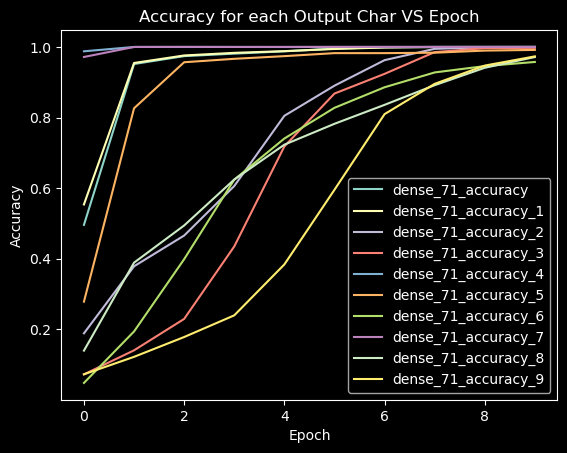

In [454]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re 

plot_metrics_vs_epoch(model_history=history)


### 3. Predict on Test Examples

In [ ]:
def predict_date(model, date, verbose=False):
    """
    Return translation of the human written date to unified machine date format.

    Parameters
    ----------
    date : str or list or np.ndarray
        A date string or an array of date strings

    Returns
    -------
    A date string or an array of date strings in unified machine format.
    """
    assert isinstance(date, np.ndarray) or isinstance(date, list) or isinstance(date, str), 'date MUST be a string of date or an array of date strings.'
    
    if isinstance(date, str):
        print(type(date))
        date=np.array([date])
        print(type(date))
        print(date)
        print(len(date))
        
    s0 = np.zeros((len(date),n_s))
    c0 = np.zeros((len(date),n_s))

    # prepare test examples
    _,_, X_tokenized_pad_oh_test = prepare_X(X=date,X_vis='X', tokenizer=tokenizer_X, max_len=Tx, vocab=char_to_index_X, idx_vis=0, verbose=verbose)

    # predict
    pred_softmax = model.predict([X_tokenized_pad_oh_test, s0, c0])
    pred_num = np.argmax(pred_softmax, axis=-1)
    pred_char = [[index_to_char_y[n] for n in e] for e in pred_num]
    pred_joined = [''.join(e) for e in np.array(pred_char).T]

    result_df = pd.DataFrame({'test_examples': date, 'pred': pred_joined})

    return result_df

In [460]:
test_examples = ['3 beautiful May 1979','3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']

#predict_date(model=model_rnn, date=test_examples)
pred = predict_model(
            model=model_rnn, 
            date=X_test, 
            n_s=n_s, 
            index_to_char_y=index_to_char_y, 
            tokenizer_X=tokenizer_X, 
            tokenizer_y=tokenizer_y, 
            char_to_index_X=char_to_index_X, 
            Tx=Tx, 
            verbose=False)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** predict_model *** 
X_tokenized_pad_oh_test.shape (300, 30, 37)
s0, c0:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,test_examples,pred
0,15 december 1994,1994-12-15
1,monday september 7 2015,2015-09-07
2,friday april 23 1982,1982-04-23
3,9/10/00,2000-09-10
4,thursday december 30 1999,1999-12-30
...,...,...
295,28 jan 2005,2005-01-28
296,28 apr 2000,2000-04-28
297,tuesday may 24 2005,2005-05-24
298,18 october 2004,2004-10-18


In [306]:
result_df = predict_date(model=model,date='Saturday 9 May 2018', verbose=False)
result_df['pred'].values[0]

<class 'str'>
<class 'numpy.ndarray'>
['Saturday 9 May 2018']
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


'2018-05-09'

### 4. Visualize Attention Coeficients

Visualize attention weights. The goal: just to get understanding of how they work.

In [307]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['input_layer_16', 's0', 'bidirectional_15', 'repeat_vector_16', 'concatenate_16', 'dense_48', 'dense_49', 'attention_weights', 'dot_16', 'c0', 'lstm_31', 'dense_50']


In [328]:
# first fit attention model to get coeficients
# attention_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']*Ty)
# attention_model.fit([X_tokenized_pad_oh, s0, c0], outputs, epochs=10, batch_size=100, verbose=False)

test_example = ['Saturday 9 May 2018']

s0 = np.zeros((len(test_example),n_s))
c0 = np.zeros((len(test_example),n_s))

# prepare test examples
test_example_x_tokenized, test_example_x_pad, test_example_x_oh = prepare_X(X=test_example,X_vis='X', tokenizer=tokenizer_X, max_len=Tx, vocab=char_to_index_X, idx_vis=0, verbose=False)

# attention_weights = attention_model.predict([test_example_x_oh, s0, c0])
# attention_weights

# Get a sample input to test
#attention_weights, energies_weights, e_weights = attention_inspector.predict([test_example_x_oh, s0, c0])
pred = model.predict([test_example_x_oh, s0, c0])
#attention_weights = attention_model.predict([test_example_x_oh, s0, c0])
attention_weights, energies_weights, e_weights = attention_inspector.predict([test_example_x_oh, s0, c0])

print(np.array(attention_weights).shape)

attention_weights = np.squeeze(np.array(attention_weights))
energies_weights = np.array(energies_weights)[:,0,:,0]#.reshape(30,10)
print(np.array(attention_weights).shape)
#print("attention_weights: ", attention_weights)
#print("energies_weights: ", np.array(energies_weights))
#print("e_weights: ", np.array(e_weights))
#print(pred)
print([index_to_char_y[n] for n in np.argmax(np.array(pred),axis=-1).ravel()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(10, 1, 30, 1)
(10, 1, 30, 1)
(10, 30)
['2', '0', '1', '8', '-', '0', '5', '-', '0', '9']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
pred_layer.shape (1, 30, 10)


Text(0.5, 1.0, 'Attention weights')

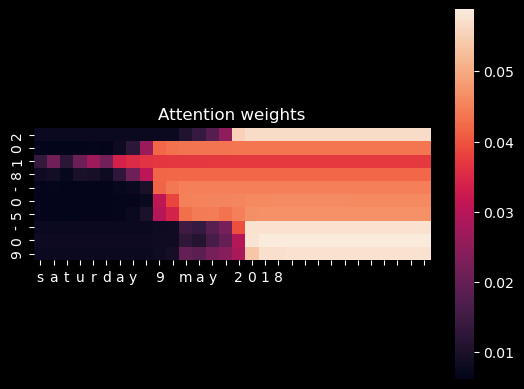

In [344]:
# First, predict date for the test example
# After that extract predictions per the layer responsible for calculating attention weights

test_example = ['Saturday 9 May 2018']

result_df = translate_date(model=model_rnn, date=test_example, verbose=False)
pred = result_df['pred'].values[0]

# build the model giving a layer output
layer_vis = 'dense_48' #'attention_weights'

model_from_layer = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_vis).output)
#model_from_layer = tf.keras.models.Model(inputs=model.input, outputs=[model.get_layer(layer_vis).get_output_at(t) for t in range(Ty)])

# layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
s0 = np.zeros((len(test_example),n_s))
c0 = np.zeros((len(test_example),n_s))

# prepare test examples
test_example_x_tokenized, test_example_x_pad, test_example_x_oh = prepare_X(X=test_example,X_vis='X', tokenizer=tokenizer_X, max_len=Tx, vocab=char_to_index_X, idx_vis=0, verbose=False)
test_example_x_pad_char = [index_to_char_X[n] for n in test_example_x_pad.ravel()]
# predict layer output
pred_layer = model_from_layer.predict([test_example_x_oh, s0, c0])
# apply relu to output
#pred_layer = np.maximum(0, pred_layer)
print('pred_layer.shape', pred_layer.shape)

pred_layer = np.squeeze(np.array(pred_layer))
attention_weights = np.array(attention_weights)#.reshape(30,10)
energies_weights = np.array(energies_weights)#.reshape(30,10)

# process prediction
test_example_y_tokenized, test_example_y_pad, test_example_y_oh = prepare_X(X=list(pred),X_vis='pred', tokenizer=tokenizer_y, max_len=Ty, vocab=char_to_index_y, idx_vis=0, verbose=False)
layer_output_n = test_example_y_pad.T[0]
layer_output_char = [index_to_char_y[n] for n in layer_output_n]

# combine input-output and layers values into dataframe (pivot)
combo_df = pd.DataFrame(attention_weights, index=layer_output_char, columns=test_example_x_pad_char)
#print(combo_df)

#combo_df = combo_df.iloc[::-1]
#plt.imshow(attention_weights)
sns.heatmap(data=combo_df, annot=False,xticklabels=combo_df.columns, yticklabels=combo_df.index,square=True, cbar=True)
plt.title('Attention weights')

Somethin wrong.. need to investigate later.

### The function from Coursera, for comparison (my ^ above it seems gives not correct result)

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.utils import to_categorical

def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s=64, num=7):
    """
    Plot the attention map for a given input text and its output prediction using attention weights.
    
    Arguments:
    modelx -- trained model with attention mechanism
    input_vocabulary -- dictionary mapping input characters to indices
    inv_output_vocabulary -- dictionary mapping output indices back to characters
    text -- input string (e.g., 'Saturday 9 May 2018')
    n_s -- size of hidden state
    num -- index to retrieve the attention layer in case the layers have multiple outputs
    """
    # Initialize attention map with zeros, shape (Ty, Tx)
    attention_map = np.zeros((10, 30))  # Assuming 10 output tokens and 30 input tokens, modify accordingly
    
    # Get layer from the model
    layer = modelx.get_layer('attention_weights')  # If the layer name is different, modify this

    Ty, Tx = attention_map.shape  # Output and input lengths
    print('Tx: ', Tx)

    # Get model inputs
    X = modelx.inputs[0]  # Input date string
    s0 = modelx.inputs[1]  # Initial hidden state
    c0 = modelx.inputs[2]  # Initial cell state
    print(X.shape)

    # Get the Bi-LSTM output layer (attention is calculated over this)
    a = modelx.layers[2](X)  # Assuming Bi-LSTM layer is 3rd, change index if different

    # Placeholder to store attention energies
    outputs = []

    # Rebuild the process to fetch attention weights
    for t in range(Ty):
        s_prev = modelx.layers[3](s0)  # Repeating s0 for attention computation
        concat = modelx.layers[4]([a, s_prev])  # Concatenate hidden states
        e = modelx.layers[5](concat)  # Dense layer to compute energies
        energies = modelx.layers[6](e)  # Dense layer for energy output
        alphas = modelx.layers[7](energies)  # Attention weights
        context = modelx.layers[8]([alphas, a])  # Context vector
        s, _, c = modelx.layers[10](context, initial_state=[s0, c0])  # Post-attention LSTM
        outputs.append(energies)  # Store attention energies for visualization

    # Define a new model to get attention energies
    f = Model(inputs=[X, s0, c0], outputs=outputs)
    
    # Prepare the input data (convert text into its encoded representation)
    s0 = np.zeros((1, n_s))  # Initialize hidden state
    c0 = np.zeros((1, n_s))  # Initialize cell state
    print([input_vocabulary[char.lower()] for char in text])
    text = (text.lower()+' '*(Tx-len(text)))
    print(text)
    print(len(text))
    encoded = np.array([input_vocabulary[char.lower()] for char in text]).reshape((1, Tx))  # Encode input
    #encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))
    print(len(input_vocabulary))
    print(encoded.shape)
    print(encoded)

    #print(f.summary())
    # Get the attention weights for the input text
    r = f.predict([encoded, s0, c0])
        
    # Fill the attention map with the extracted energies
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]  # Assign energies to the attention map

    # Normalize the attention map for better visualization
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]  # Normalize per row (output token)

    # Get model's prediction for the input sequence
    prediction = modelx.predict([encoded, s0, c0])
    predicted_text = [inv_output_vocabulary[np.argmax(pred)] for pred in prediction]

    # Plot the attention map as a heatmap
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # Add the heatmap image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # Add a colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # Add labels
    ax.set_yticks(range(Ty))
    ax.set_yticklabels(predicted_text[:Ty])

    ax.set_xticks(range(len(text)))
    ax.set_xticklabels(list(text), rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # Add grid for better visualization
    ax.grid()

    plt.show()
    
    return attention_map

plot_attention_map(modelx=model, input_vocabulary=char_to_index_X, inv_output_vocabulary=index_to_char_y, text=test_example[0], n_s = 128, num = 7)

Tx:  30
(None, 30, 37)
[13, 5, 18, 11, 9, 12, 5, 10, 2, 7, 2, 17, 5, 10, 2, 4, 6, 3, 15]
saturday 9 may 2018           
30
37
(1, 30, 37)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]]


Model: "functional_137"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 30, 64)    │     17,920 │ input_layer_16[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0],         │
│                     │                   │            │ s0[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 30, 128)   │          0 │ bidirectional_15… │
│ (Concatenate)       │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
│                     │                   │            │ bidirectional_15… │
│                     │                   │            │ repeat_vector_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 30, 10)    │      1,290 │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2… │
│                     │                   │            │ concatenate_16[2

 Total params: 19,221 (75.08 KB)

 Trainable params: 19,221 (75.08 KB)

 Non-trainable params: 0 (0.00 B)

None


ValueError: Input 1 of layer "functional_137" is incompatible with the layer: expected shape=(None, 64), found shape=(1, 128)

##### Test Scripts

In [2]:
ss = set()
s1 = 'd MMMM YYY'
s2 = 'a BBBB CcC'
ss.update(tuple(s1))
print(ss)
ss.update(tuple(s2))
print(ss)

{'d', ' ', 'Y', 'M'}
{'Y', 'a', 'C', 'd', 'B', 'M', ' ', 'c'}


### Model by chartgpt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate
from tensorflow.keras.models import Model

def create_model(input_dim, output_dim, latent_dim):
    # Input layers
    encoder_inputs = Input(shape=(None, input_dim))
    decoder_inputs = Input(shape=(None, output_dim))
    
    # Encoder LSTM
    encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder LSTM
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    # Attention
    attention = Attention()([decoder_outputs, encoder_outputs])
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention])
    
    # Output layer
    decoder_dense = Dense(output_dim, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

# Instantiate model
model = create_model(input_dim=your_input_dim, output_dim=your_output_dim, latent_dim=256)


In [ ]:
def create_inference_model(encoder_inputs, decoder_inputs):
    encoder_model = Model(encoder_inputs, encoder_outputs)
    
    # Define the decoder model
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(None, latent_dim))

    # Repeat the decoder input for attention
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=[decoder_state_input_h, decoder_state_input_c])

    # Attention layer
    attention = Attention()([decoder_outputs, decoder_hidden_state_input])
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention])
    
    # Output layer
    decoder_outputs = decoder_dense(decoder_combined_context)

    decoder_model = Model(
        [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c, decoder_hidden_state_input],
        [decoder_outputs] + [state_h, state_c]
    )
    return encoder_model, decoder_model

# Inference models
encoder_model, decoder_model = create_inference_model(encoder_inputs, decoder_inputs)


In [ ]:
# Define your test data
test_example = np.array([[...], [...], ...])  # Replace with your tokenized input
decoder_input_seq = np.array([[...], [...], ...])  # Replace with your tokenized output

# Run the encoder model to get the encoder outputs
encoder_output = encoder_model.predict(test_example)

# Initialize the decoder states
state_h, state_c = ...  # Initialize with zeros or from the encoder output

# Loop through the decoder time steps
attention_weights_list = []
for t in range(output_length):  # Define output_length as per your output sequence
    # Run the decoder model
    decoder_output, state_h, state_c = decoder_model.predict([decoder_input_seq[:, t:t + 1], state_h, state_c, encoder_output])
    
    # Extract attention weights
    attention_weights = ...  # Modify to extract the attention weights as needed
    attention_weights_list.append(attention_weights)

# Convert list to array
attention_weights_array = np.array(attention_weights_list)  # Shape: (output_length, input_length)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the actual tokenized input/output sequences
input_sequence = ['3', 'May', '1979', '<PAD>', '<PAD>']  # Example input sequence
output_sequence = ['1', '9', '7', '9', '-']  # Example output sequence

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights_array, annot=True, cmap='Blues', xticklabels=input_sequence, yticklabels=output_sequence)

# Customize labels and title
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.title('Attention Weights Heatmap')

# Show the heatmap
plt.show()
